Dataset Shape: (1143, 13)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9

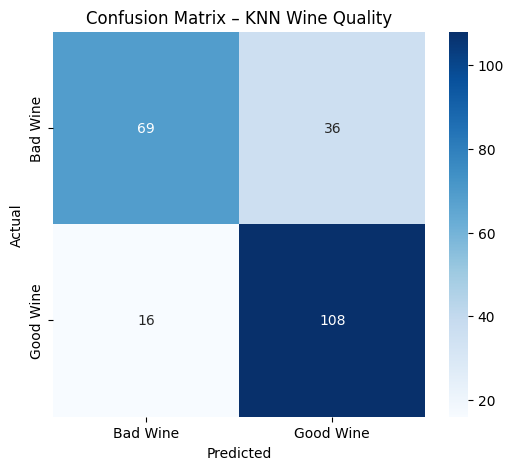

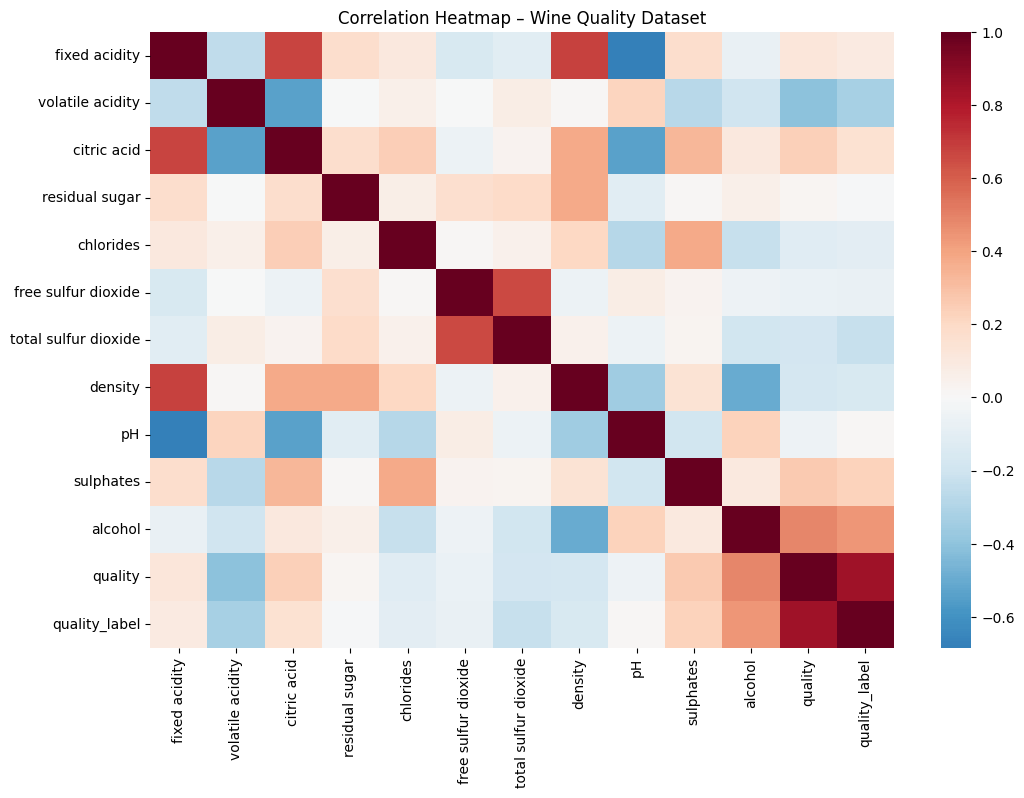

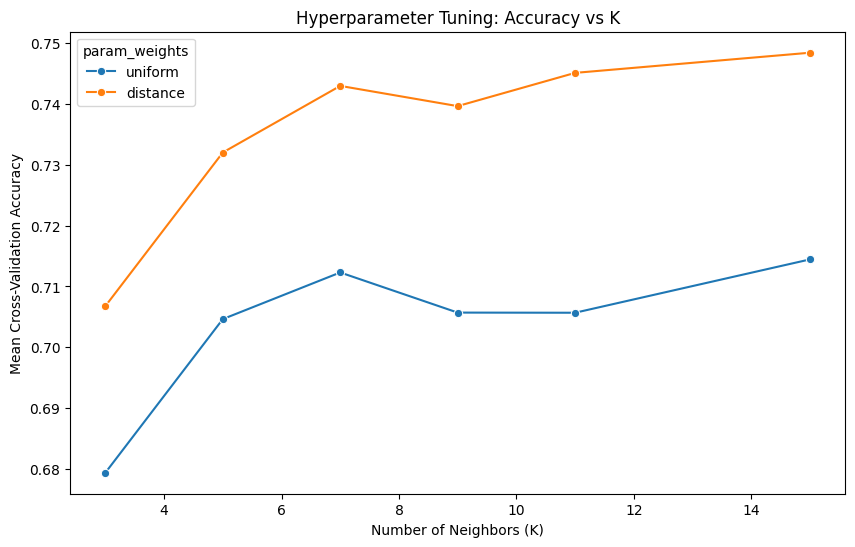

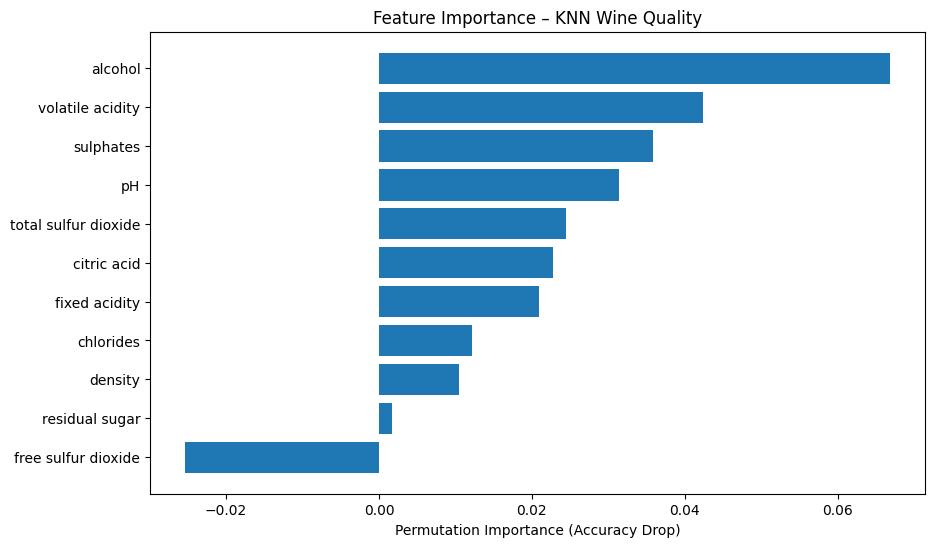

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# =========================
# 1. Load Dataset
# =========================
df = pd.read_csv("dataset.csv")   # change name if needed
df.columns = df.columns.str.strip()

print("Dataset Shape:", df.shape)
print(df.head())

# =========================
# 2. Drop ID column (NOT a feature)
# =========================
if 'Id' in df.columns:
    df = df.drop('Id', axis=1)

# =========================
# 3. Convert to Binary Classification
#    Good wine: quality >= 6
# =========================
df['quality_label'] = (df['quality'] >= 6).astype(int)

X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

# =========================
# 4. Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 5. Feature Scaling (MANDATORY for KNN)
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# 6. KNN + Hyperparameter Tuning
# =========================
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", round(grid_search.best_score_, 4))

# =========================
# 7. Evaluation
# =========================
y_pred = best_model.predict(X_test_scaled)

print("\nFinal Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# =========================
# 8. Confusion Matrix
# =========================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Bad Wine', 'Good Wine'],
    yticklabels=['Bad Wine', 'Good Wine']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – KNN Wine Quality")
plt.show()

# =========================
# 9. Correlation Heatmap
# =========================
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='RdBu_r', center=0)
plt.title("Correlation Heatmap – Wine Quality Dataset")
plt.show()

# =========================
# 10. Accuracy vs Number of Neighbors (K)
# =========================
results_df = pd.DataFrame(grid_search.cv_results_)
subset = results_df[results_df['param_metric'] == 'euclidean']

plt.figure(figsize=(10,6))
sns.lineplot(
    data=subset,
    x='param_n_neighbors',
    y='mean_test_score',
    hue='param_weights',
    marker='o'
)
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("Hyperparameter Tuning: Accuracy vs K")
plt.show()

# =========================
# 11. Permutation Feature Importance
# =========================
perm_importance = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(
    X.columns[sorted_idx],
    perm_importance.importances_mean[sorted_idx]
)
plt.xlabel("Permutation Importance (Accuracy Drop)")
plt.title("Feature Importance – KNN Wine Quality")
plt.show()
